In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Add in the correct locations for NeuroPy repositories on your computer(s) here:
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
else:    # For mac
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.plotting.spikes import plot_raster
from neuropy.plotting.signals import plot_signal_w_epochs


In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more/less than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):
    """Load in data. Uses current directory as default"""

    return ProcessData(basepath)

In [5]:
dir_use = '/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training'  # Add directory here!
sess = sess_use(dir_use)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [6]:
print(sess.eegfile)

duration: 12444.12 seconds 
duration: 3.46 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [8]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=6, 
                                    edge_cutoff=1, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')  # Write to neuroscope
    art_epochs.save(art_epochs_file)
art_epochs

Existing artifact epochs file loaded


17 epochs
Snippet: 
        start       stop label
0   159.8936   169.9824      
1   408.4080   417.0392      
2   859.9032   861.1408      
3  1131.7512  1133.0208      
4  1388.4056  1389.6752      

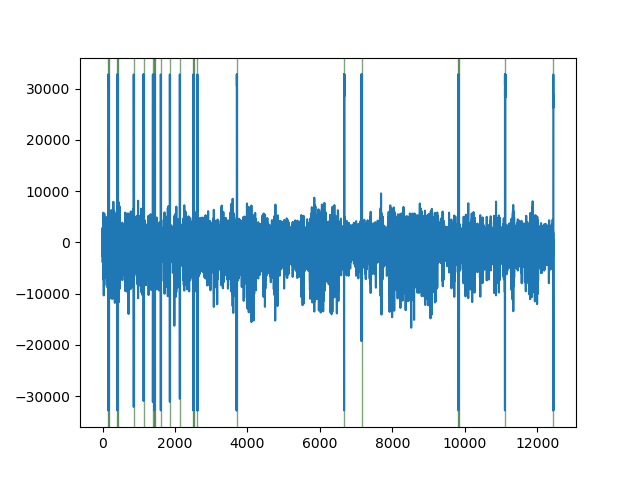

In [9]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(signal.time, signal.traces[10])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


##  Write artifacts to dead file for spyking circus

In [10]:
from neuropy.io.spykingcircusio import SpykingCircusIO

SpykingCircusIO.write_epochs(sess.basepath / 'dead_times.txt', 
                            art_epochs)

dead_times.txt created


## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.probegroup.npy saved


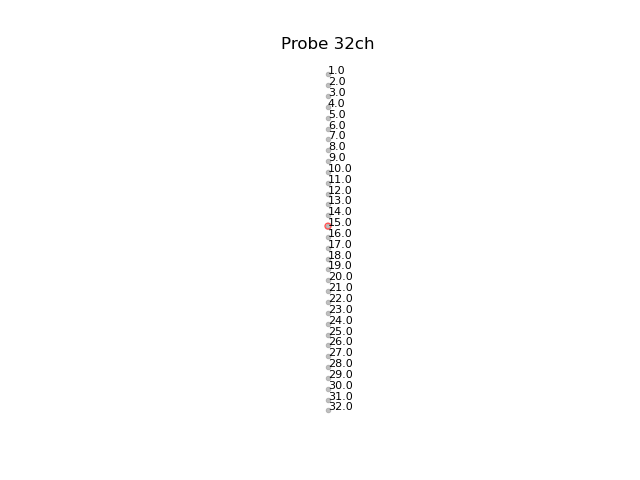

In [11]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(32, 0, -1))
shank.set_disconnected_channels([15])
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect SWRs

In [13]:
# NRK - this does not seem to be doing a good job - too few ripples!
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 5  # Set to None for automatic detection
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)
ripple_epochs

Selected channels for ripples: [5]
4167 epochs remaining with durations within (0.05,0.45)


4167 epochs
Snippet: 
      start     stop  peak_time  peak_power label
0   3.8320   4.0864     3.9896    5.990347      
1  11.2968  11.3760    11.3440    3.112436      
2  18.4456  18.5680    18.5408    3.734424      
3  21.9448  22.0440    22.0072    6.565239      
4  27.1336  27.2880    27.2488    4.515885      

### Write to files

In [14]:
ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
ripple_epochs.save(ripple_epochs.source_file)  # save to .npy file
sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')  # save for neuroscope event file

/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/Han_training.ripple.npy saved


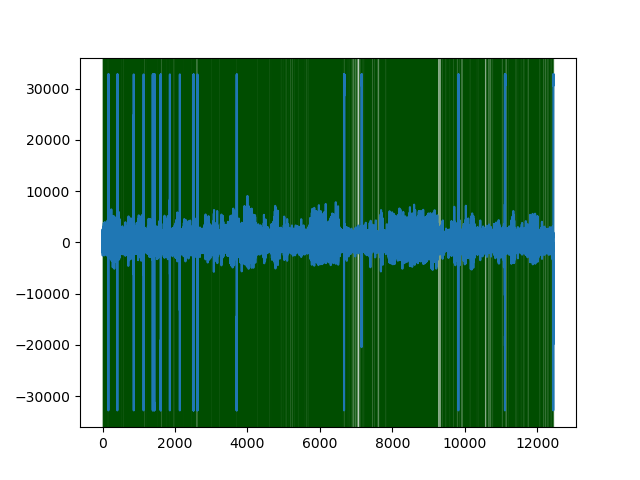

In [15]:
# plot stuff!
%matplotlib widget
_, ax = plt.subplots()
ax.plot(signal.time, signal.traces[5])

for start, stop in zip(ripple_epochs.starts, ripple_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


# Detect Sharp Waves 

In [ ]:
# Similar flow to SWR detection but using a different function in neuropy.analyses.oscillation

In [ ]:
from neuropy.analyses.oscillations import detect_sharpwave_epochs
swave_channel=11
sharpwave_epochs = detect_sharpwave_epochs(signal, prbgrp, sharpwave_channel=swave_channel, 
                                           ignore_epochs=art_epochs)

In [ ]:
sess.recinfo.write_epochs(sharpwave_epochs, ext="swv")
sess.recinfo.write_epochs(ripple_epochs, ext="swr")

# Detect Theta epochs

In [ ]:
signal = sess.eegfile.get_signal()

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, 3.5)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 5

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, 
                                                    return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur,
                                                    thresh=thresh, edge_cutoff=edge_cutoff, 
                                                    ignore_epochs=art_epochs, return_power=True)

# Save this notebook to working directory after you are done for reference

In [18]:
import ipynbname
import shutil
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

nb_copy_savename = sess.basepath / 'artifact_and_epoch_detection.ipynb'
shutil.copy(str(nb_path), str(nb_copy_savename))

'/data2/Trace_FC/Recording_Rats/Han/2022_08_03_training/artifact_and_epoch_detection.ipynb'